In [21]:
from pysad.evaluation import AUROCMetric
from pysad.models import xStream, ExactStorm, HalfSpaceTrees, IForestASD, KitNet, KNNCAD, LODA, LocalOutlierProbability, \
    MedianAbsoluteDeviation, RelativeEntropy, RSHash, RobustRandomCutForest, StandardAbsoluteDeviation
from pysad.transform.probability_calibration import ConformalProbabilityCalibrator
from river import compose
from river import datasets
from river import metrics
from river import preprocessing
from river import anomaly

import numpy as np

import matplotlib.pyplot as plt


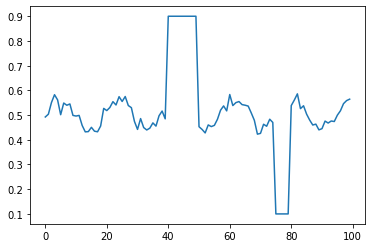

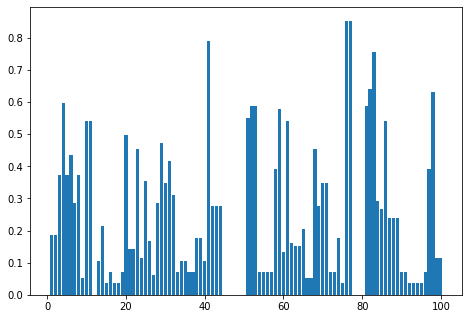

In [22]:
# X = [0.5, 0.45, 0.43, 0.44, 0.445, 0.45, 0.0]
# X = np.random.binomial(10,0.5,1000)/10
dur = 100
f0 = 1
fs = 3
t = np.arange(dur)
sinusoid = np.sin((t * f0/fs) )
noise = np.random.normal(0,0.3,dur)
X = (sinusoid + noise + 8)/16
Y = np.zeros(len(X))

# Drop values high and label Y
X[40:50] = 0.9
Y[40:50] = 1

# Drop values low
X[75:80] = 0.1
Y[75:80] = 1

hst = anomaly.HalfSpaceTrees(
     n_trees=5,
     height=3,
     window_size=3,
     seed=42
 )
auc = metrics.ROCAUC()
for x in X[:3]:
    hst = hst.learn_one({'x': x})  # Warming up

score_list = []
i =0
for x in X:
    features = {'x': x}
    hst = hst.learn_one(features)
    score = hst.score_one(features)
    score_list.append(score)
    auc = auc.update(Y[i], score)
    i += 1
#     print(f'Anomaly score for x={x:.3f}: {score:.3f}')
# print(score_list)

# Dataset
fig = plt.figure()
# ax = fig.add_axes([0,0,1,1])
plt.plot(X)
# ax.plot(np.arange(1,1001),X)
plt.show()


## PySad

In [23]:
model = xStream()  # Init model.
calibrator = ConformalProbabilityCalibrator(windowed=True, window_size=300)
streaming_data = X  # Get streamer.

xstream_count = 0
xstream_score = []

for x in X:
        anomaly_score = model.fit_score_partial(x)  # Fit to an instance x and score it.

        calibrated_score = calibrator.fit_transform(anomaly_score)  # Fit & calibrate score.
        xstream_score.append(calibrated_score)
        # Output if the instance is anomalous.
        if calibrated_score > 0.95:
            xstream_count += 1# If probability of being normal is less than 5%.
        # print(f"Alert: {i}th data point is anomalous.")
print(f'Anamolies detected: {xstream_count}')

Anamolies detected: 4


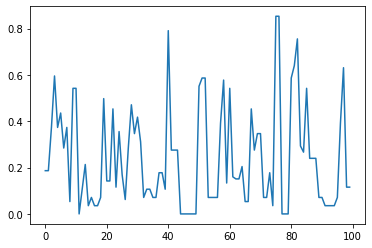

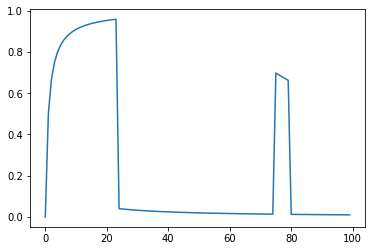

In [24]:
plt.figure()
plt.plot(score_list)
plt.figure()
plt.plot(xstream_score)


In [25]:
# model_count = {key:0 for key in model_classes}
# model_score = {key:[] for key in model_classes}
# calibrators = {key:ConformalProbabilityCalibrator(windowed=True, window_size=300) for key in model_classes}
# print(model_count.keys())

# X_IForestASD = np.reshape(X, (-1, 2))
# model_cls = IForestASD()
model_classes = {
        # ExactStorm().__class__.__name__: { "model": ExactStorm(),
        #                                "calibrator": ConformalProbabilityCalibrator(windowed=True, window_size=300),
        #                                "data": np.reshape(X, (-1, 2)),
        #                                "count": 0,
        #                                "scores": []},
        # HalfSpaceTrees.__name__: { "model": HalfSpaceTrees([0.0],[1.0]),
        #                                "calibrator": ConformalProbabilityCalibrator(windowed=True, window_size=300),
        #                                "data": X,
        #                                "count": 0,
        #                                "scores": []},
        IForestASD().__class__.__name__: { "model": xStream(),
                                           "calibrator": ConformalProbabilityCalibrator(windowed=True, window_size=300),
                                           "data": np.reshape(X, (-1, 1)),
                                           "count": 0,
                                           "scores": [],
                                           "metric": AUROCMetric()},
        # KitNet().__class__.__name__: { "model":KitNet(),
        #                                "calibrator": ConformalProbabilityCalibrator(windowed=True, window_size=300),
        #                                "data": np.reshape(X, (-1, 1)),
        #                                "count": 0,
        #                                "scores": []},
        # KNNCAD: {"probationary_period": 50},
        LODA().__class__.__name__: { "model":LODA(),
                               "calibrator": ConformalProbabilityCalibrator(windowed=True, window_size=300),
                               "data": np.reshape(X, (-1, 1)),
                               "count": 0,
                               "scores": [],
                                "metric": AUROCMetric()},
        # LocalOutlierProbability.__name__: { "model":LocalOutlierProbability(False),
        #                    "calibrator": ConformalProbabilityCalibrator(windowed=True, window_size=300),
        #                    "data": np.reshape(X, (-1, 1)),
        #                    "count": 0,
        #                    "scores": []},
        # MedianAbsoluteDeviation: [{}, { "absolute": False }],
        # RelativeEntropy.__name__: { "model":RelativeEntropy(0.0, 1.0),
        #                        "calibrator": ConformalProbabilityCalibrator(windowed=True, window_size=300),
        #                        "data": np.reshape(X, (-1, 1)),
        #                        "count": 0,
        #                        "scores": []},
        # RSHash: {"feature_mins": [0.0], "feature_maxes": [1.0]},
        # StandardAbsoluteDeviation: [{}, {"absolute": False}],
        xStream().__class__.__name__: {"model": xStream(),
                                       "calibrator": ConformalProbabilityCalibrator(windowed=True, window_size=300),
                                       "data": X,
                                       "count": 0,
                                       "scores": [],
                                        "metric": AUROCMetric()},
        # RobustRandomCutForest().__class__.__name__: {"model": RobustRandomCutForest(),
        #                            "calibrator": ConformalProbabilityCalibrator(windowed=True, window_size=300),
        #                            "data": np.reshape(X, (-1, 1)),
        #                            "count": 0,
        #                            "scores": [],
        #                             "metric": AUROCMetric()}
    }
for key, props in model_classes.items():
    i = 0
    for x in props["data"]:
        anomaly_score = props["model"].fit_score_partial(x) # Fit to an instance x and score it.
        if anomaly_score:
            calibrated_score = props["calibrator"].fit_transform(anomaly_score)
        else:
            calibrated_score = anomaly_score
        props["metric"].update(Y[i], calibrated_score)

        props["scores"].append(calibrated_score)
        # Output if the instance is anomalous.
        if calibrated_score > 0.90:
            props["count"] += 1# If probability of being normal is less than 5%.
            # print(f"Alert: {i}th data point is anomalous.")
        i += 1
print("Done")


Done


Anomalies detected for IForestASD: 14 & ROC: 0.611764705882353
Anomalies detected for LODA: 6 & ROC: 0.6345098039215686
Anomalies detected for xStream: 14 & ROC: 0.611764705882353
ROC HST River: ROCAUC: 0.432941


Text(0.5, 1.0, 'Detection Method: River HST')

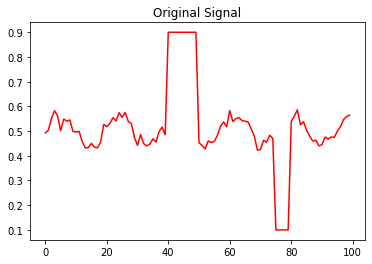

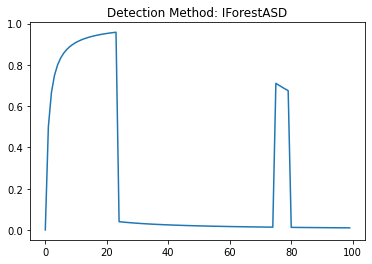

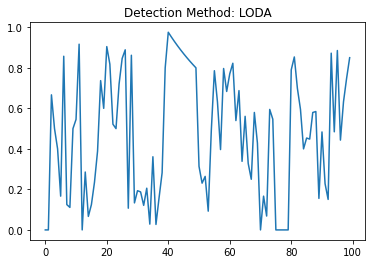

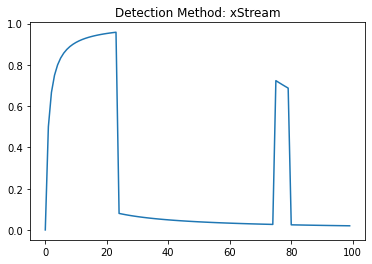

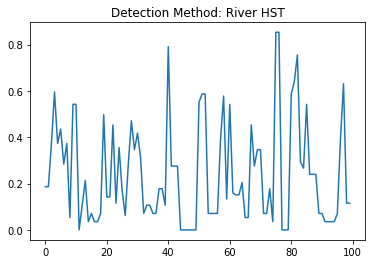

In [26]:
fig = plt.figure()
plt.plot(X,'r')
plt.title("Original Signal")
for key, props in model_classes.items():
    print(f'Anomalies detected for {key}: {props["count"]} & ROC: {props["metric"].get()}')
print(f'ROC HST River: {auc}')
for key, props in model_classes.items():
    plt.figure()
    plt.plot(props["scores"],label=key)
    plt.title(f"Detection Method: {key}")

plt.figure()
plt.plot(score_list)
plt.title("Detection Method: River HST")